# Importando bibliotecas e dataset


In [2]:
import kagglehub
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import math
import optuna
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split,KFold,cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score
from scipy.stats import ks_2samp

C:\Users\maria\miniconda3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
path = kagglehub.dataset_download("kapturovalexander/customers-churned-in-telecom-services")
print("Path to dataset files:", path)

Path to dataset files: C:\Users\maria\.cache\kagglehub\datasets\kapturovalexander\customers-churned-in-telecom-services\versions\3


In [4]:
df = pd.read_csv(path + '/customer_churn_telecom_services.csv')

# Funções Auxiliares

In [5]:
def plotHistogram(dataset,new = None):

    column_exclusions = []

    if new:
      column_exclusions = ["tenure", "MonthlyCharges", "TotalCharges"]

    if type(dataset) == pd.Series:
        dataset = dataset.to_frame()

    columns_to_plot = [col for col in dataset.columns if col not in column_exclusions]
    colorList = ["blue", "red", "green", "orange", "purple", "pink", "brown", "gray", "cyan", "magenta"]


    num_cols = len(columns_to_plot)
    rows = math.ceil(num_cols / 3)

    fig, axes = plt.subplots(rows, 3, figsize=(15, 5 * rows))
    axes = axes.flatten()

    for i, columnName in enumerate(columns_to_plot):
        ax = axes[i]

        if dataset[columnName].dtype == 'object' or dataset[columnName].dtype.name == 'category':
            dataset[columnName].value_counts().plot(kind='bar', color=random.choice(colorList), edgecolor='black', ax=ax)
            ax.set_title(f"Bar Plot of {columnName}")
            ax.set_xlabel(columnName)
            ax.set_ylabel("Frequency")
            ax.tick_params(axis='x', rotation=45)

        else:
            ax.hist(dataset[columnName].dropna(), bins='auto', color=random.choice(colorList), edgecolor='black')
            ax.set_title(f"Histogram of {columnName}")
            ax.set_xlabel(columnName)
            ax.set_ylabel("Frequency")

        ax.grid(axis='y', linestyle='--', alpha=0.7)

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()


In [6]:
def fix_missing_values_median(train_df, val_df, test_df, column):
    if column not in train_df.columns:
        raise ValueError(f"Coluna '{column}' não encontrada no conjunto de treino!")

    train_df_copy = train_df.copy()
    val_df_copy = val_df.copy()
    test_df_copy = test_df.copy()

    median_value = train_df_copy[column].median()

    train_df_copy[column].fillna(median_value, inplace=True)
    val_df_copy[column].fillna(median_value, inplace=True)
    test_df_copy[column].fillna(median_value, inplace=True)

    return train_df_copy, val_df_copy, test_df_copy

In [7]:
def fix_missing_values_knn(train_df, val_df, test_df, column, n_neighbors=5):
    if column not in train_df.columns:
        raise ValueError(f"Coluna '{column}' não encontrada no conjunto de treino!")

    train_df_copy = train_df.copy()
    val_df_copy = val_df.copy()
    test_df_copy = test_df.copy()

    numeric_cols = train_df_copy.select_dtypes(include=['number']).columns

    imputer = KNNImputer(n_neighbors=n_neighbors)

    train_df_copy[numeric_cols] = imputer.fit_transform(train_df_copy[numeric_cols])
    val_df_copy[numeric_cols] = imputer.transform(val_df_copy[numeric_cols])
    test_df_copy[numeric_cols] = imputer.transform(test_df_copy[numeric_cols])

    return train_df_copy, val_df_copy, test_df_copy

In [8]:
def plot_outliers(df):
    numeric_columns = df.select_dtypes(include=['number']).columns.tolist()

    if not numeric_columns:
        print("Nenhuma coluna numérica encontrada no DataFrame.")
        return

    fig, ax = plt.subplots(figsize=(12, 6))

    sns.boxplot(data=df[numeric_columns], ax=ax, flierprops={
        'marker': 'o',
        'markerfacecolor': 'red',
        'markeredgecolor': 'black',
        'markersize': 8
    })

    for i, col in enumerate(numeric_columns):
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        ax.text(i, upper_bound, f'{upper_bound:.2f}', ha='center', va='bottom', fontsize=10, color='blue', bbox=dict(facecolor='white', alpha=0.8))
        ax.text(i, lower_bound, f'{lower_bound:.2f}', ha='center', va='top', fontsize=10, color='blue', bbox=dict(facecolor='white', alpha=0.8))

        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        for j, value in enumerate(outliers):
            ax.plot(i, value, marker='o', markersize=8, color='red', alpha=0.6)
            ax.text(i, value, f'{value:.2f}', ha='center', va='bottom', fontsize=9, color='darkred', bbox=dict(facecolor='white', alpha=0.8))

    ax.set_xticklabels(numeric_columns, rotation=45, ha='right', fontsize=12)
    ax.set_title("Boxplot para Identificação de Outliers", fontsize=16, pad=20)
    ax.set_ylabel("Valores", fontsize=14)
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    ax.plot([], [], marker='o', markersize=8, color='red', linestyle='none', label='Outliers')
    ax.legend(loc='upper right', fontsize=12)

    plt.tight_layout()
    plt.show()

In [9]:
def remove_outliers(train_df, val_df, test_df, column):
    if column not in train_df.columns:
        raise ValueError(f"Coluna '{column}' não encontrada no conjunto de treino!")

    Q1 = train_df[column].quantile(0.25)
    Q3 = train_df[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    train_df_filtered = train_df[(train_df[column] >= lower_bound) & (train_df[column] <= upper_bound)]
    val_df_filtered = val_df[(val_df[column] >= lower_bound) & (val_df[column] <= upper_bound)]
    test_df_filtered = test_df[(test_df[column] >= lower_bound) & (test_df[column] <= upper_bound)]

    return train_df_filtered, val_df_filtered, test_df_filtered

In [10]:
def get_numeric_columns(df):
    return df.select_dtypes(include=['number']).columns.tolist()

In [11]:
def preprocess_categorical_data(train_df, val_df, test_df,
                                binary_cols=["Partner", "Dependents", "PhoneService", "PaperlessBilling", "Churn"],
                                nominal_cols=["gender", "PaymentMethod", "MultipleLines", "InternetService", "TechSupport",
                                              "StreamingTV", "StreamingMovies", "OnlineBackup", "OnlineSecurity", "DeviceProtection"],
                                ordinal_cols=["Contract","tenure"]):

    train_df_copy, val_df_copy, test_df_copy = train_df.copy(), val_df.copy(), test_df.copy()

    for col in binary_cols:
        mapping = {'Yes': 1, 'No': 0}
        train_df_copy[col] = train_df[col].map(mapping).astype(int)
        val_df_copy[col] = val_df[col].map(mapping).astype(int)
        test_df_copy[col] = test_df[col].map(mapping).astype(int)

    onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
    onehot_encoder.fit(train_df_copy[nominal_cols])

    train_onehot = onehot_encoder.transform(train_df_copy[nominal_cols])
    val_onehot = onehot_encoder.transform(val_df_copy[nominal_cols])
    test_onehot = onehot_encoder.transform(test_df_copy[nominal_cols])

    onehot_cols = onehot_encoder.get_feature_names_out(nominal_cols)

    train_onehot_df = pd.DataFrame(train_onehot, columns=onehot_cols, index=train_df.index)
    val_onehot_df = pd.DataFrame(val_onehot, columns=onehot_cols, index=val_df.index)
    test_onehot_df = pd.DataFrame(test_onehot, columns=onehot_cols, index=test_df.index)

    train_df_copy = train_df_copy.drop(columns=nominal_cols).join(train_onehot_df)
    val_df_copy = val_df_copy.drop(columns=nominal_cols).join(val_onehot_df)
    test_df_copy = test_df_copy.drop(columns=nominal_cols).join(test_onehot_df)

    ordinal_encoder = OrdinalEncoder()
    ordinal_encoder.fit(train_df_copy[ordinal_cols])

    train_df_copy[ordinal_cols] = ordinal_encoder.transform(train_df_copy[ordinal_cols])
    val_df_copy[ordinal_cols] = ordinal_encoder.transform(val_df_copy[ordinal_cols])
    test_df_copy[ordinal_cols] = ordinal_encoder.transform(test_df_copy[ordinal_cols])

    return train_df_copy, val_df_copy, test_df_copy

In [12]:
def bin_columns(df_train, df_val, df_test, column):
    if column not in df_train.columns:
        raise ValueError(f"Coluna '{column}' não encontrada no conjunto de treino!")

    # Definindo os limites dos bins para garantir que 0 e 72 sejam incluídos
    bins = [-0.1, 18, 36, 54, 72]
    labels = ["0-18", "19-36", "37-54", "55-72"]

    df_train_copy = df_train.copy()
    df_val_copy = df_val.copy()
    df_test_copy = df_test.copy()

    df_train_copy[column] = pd.cut(df_train_copy[column], bins=bins, labels=labels, right=True, include_lowest=True)
    df_val_copy[column] = pd.cut(df_val_copy[column], bins=bins, labels=labels, right=True, include_lowest=True)
    df_test_copy[column] = pd.cut(df_test_copy[column], bins=bins, labels=labels, right=True, include_lowest=True)

    return df_train_copy, df_val_copy, df_test_copy


In [13]:
def bin_and_encode(df_train, df_val, df_test):
    numerical_cols = ["tenure"]
    bins = [0, 18, 36, 54, 72]
    labels = ["0-18", "19-36", "37-54", "55-72"]

    df_train_copy = df_train.copy()
    df_val_copy = df_val.copy()
    df_test_copy = df_test.copy()

    df_train_copy["tenure"] = pd.cut(df_train_copy["tenure"], bins=bins, labels=labels,right=True)
    df_val_copy["tenure"] = pd.cut(df_val_copy["tenure"], bins=bins, labels=labels,right=True)
    df_test_copy["tenure"] = pd.cut(df_test_copy["tenure"], bins=bins, labels=labels,right=True)

    ordinal_encoder = OrdinalEncoder()
    df_train_copy[numerical_cols] = ordinal_encoder.fit_transform(df_train_copy[numerical_cols])

    df_val_copy[numerical_cols] = ordinal_encoder.transform(df_val_copy[numerical_cols])
    df_test_copy[numerical_cols] = ordinal_encoder.transform(df_test_copy[numerical_cols])

    return df_train_copy, df_val_copy, df_test_copy

In [14]:
def normalize_data(train_df, val_df, test_df):
    scaler = MinMaxScaler()
    numeric_cols = train_df.select_dtypes(include=['number']).columns

    scaler.fit(train_df[numeric_cols])

    train_df[numeric_cols] = scaler.transform(train_df[numeric_cols])
    val_df[numeric_cols] = scaler.transform(val_df[numeric_cols])
    test_df[numeric_cols] = scaler.transform(test_df[numeric_cols])

    return train_df, val_df, test_df

# 1. Eliminar variáveis identificadoras se existirem (chaves de identificação,cpf,rg,nome da pessoa).

In [15]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [16]:
df.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

Não possui variáveis identificadoras nesse dataset.



In [17]:
df["tenure"].max()

72

# 2. Dividir a base de dados em 3 subsets (k=3 folds).

In [18]:
from sklearn.model_selection import KFold, train_test_split

kf = KFold(n_splits=3, shuffle=True)

for i, (train_val_index, test_index) in enumerate(kf.split(df)):
    dfTest = df.iloc[test_index]

    dfTrain, dfVal = train_test_split(df.iloc[train_val_index], test_size=0.2, random_state=12)

    if i == 0:
        dfTrainFoldOne, dfValFoldOne, dfTestFoldOne = dfTrain, dfVal, dfTest
    elif i == 1:
        dfTrainFoldTwo, dfValFoldTwo, dfTestFoldTwo = dfTrain, dfVal, dfTest
    else:
        dfTrainFoldThree, dfValFoldThree, dfTestFoldThree = dfTrain, dfVal, dfTest

# 3.Análise Explorátoria de Dados

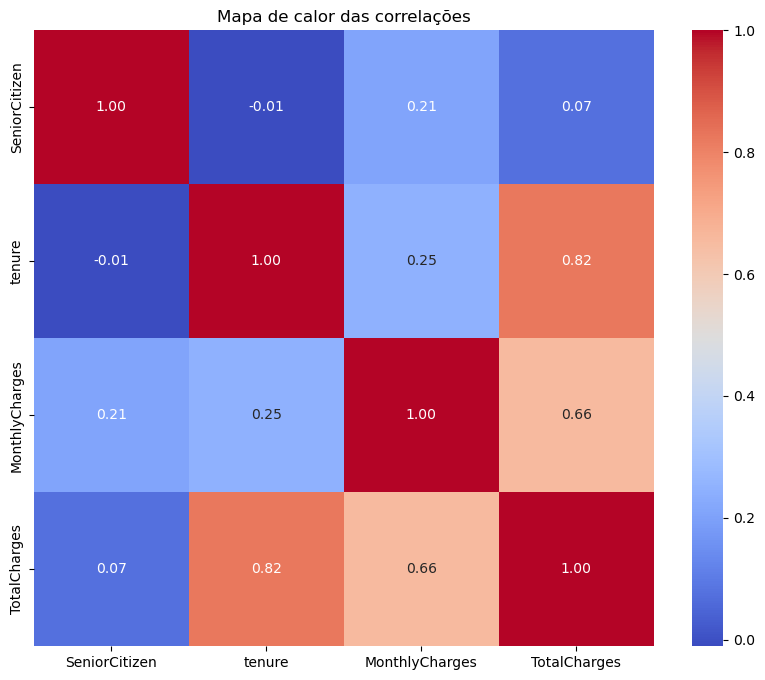

In [19]:
numericdfTrainFoldOne = dfTrainFoldOne.select_dtypes(include=["number"])

correlation_matrix = numericdfTrainFoldOne.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Mapa de calor das correlações")
plt.show()

In [20]:
dfTrainFoldOne.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
6653,Female,0,No,No,28,No,No phone service,DSL,No,No,Yes,No,No,No,Month-to-month,Yes,Mailed check,29.75,790.70,No
6125,Male,0,Yes,No,13,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Credit card (automatic),102.25,1359.00,Yes
4914,Female,0,Yes,Yes,72,Yes,Yes,DSL,Yes,Yes,No,Yes,Yes,No,Two year,No,Mailed check,74.55,5430.65,No
2786,Male,0,No,Yes,27,Yes,No,DSL,Yes,Yes,No,No,No,No,One year,No,Mailed check,56.20,1567.55,No
4238,Male,0,Yes,Yes,57,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,19.40,1061.60,No


<Axes: xlabel='Churn', ylabel='count'>

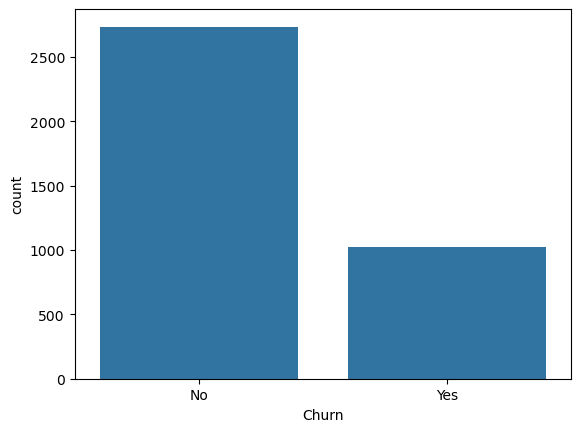

In [21]:
sns.countplot(x='Churn', data=dfTrainFoldOne)

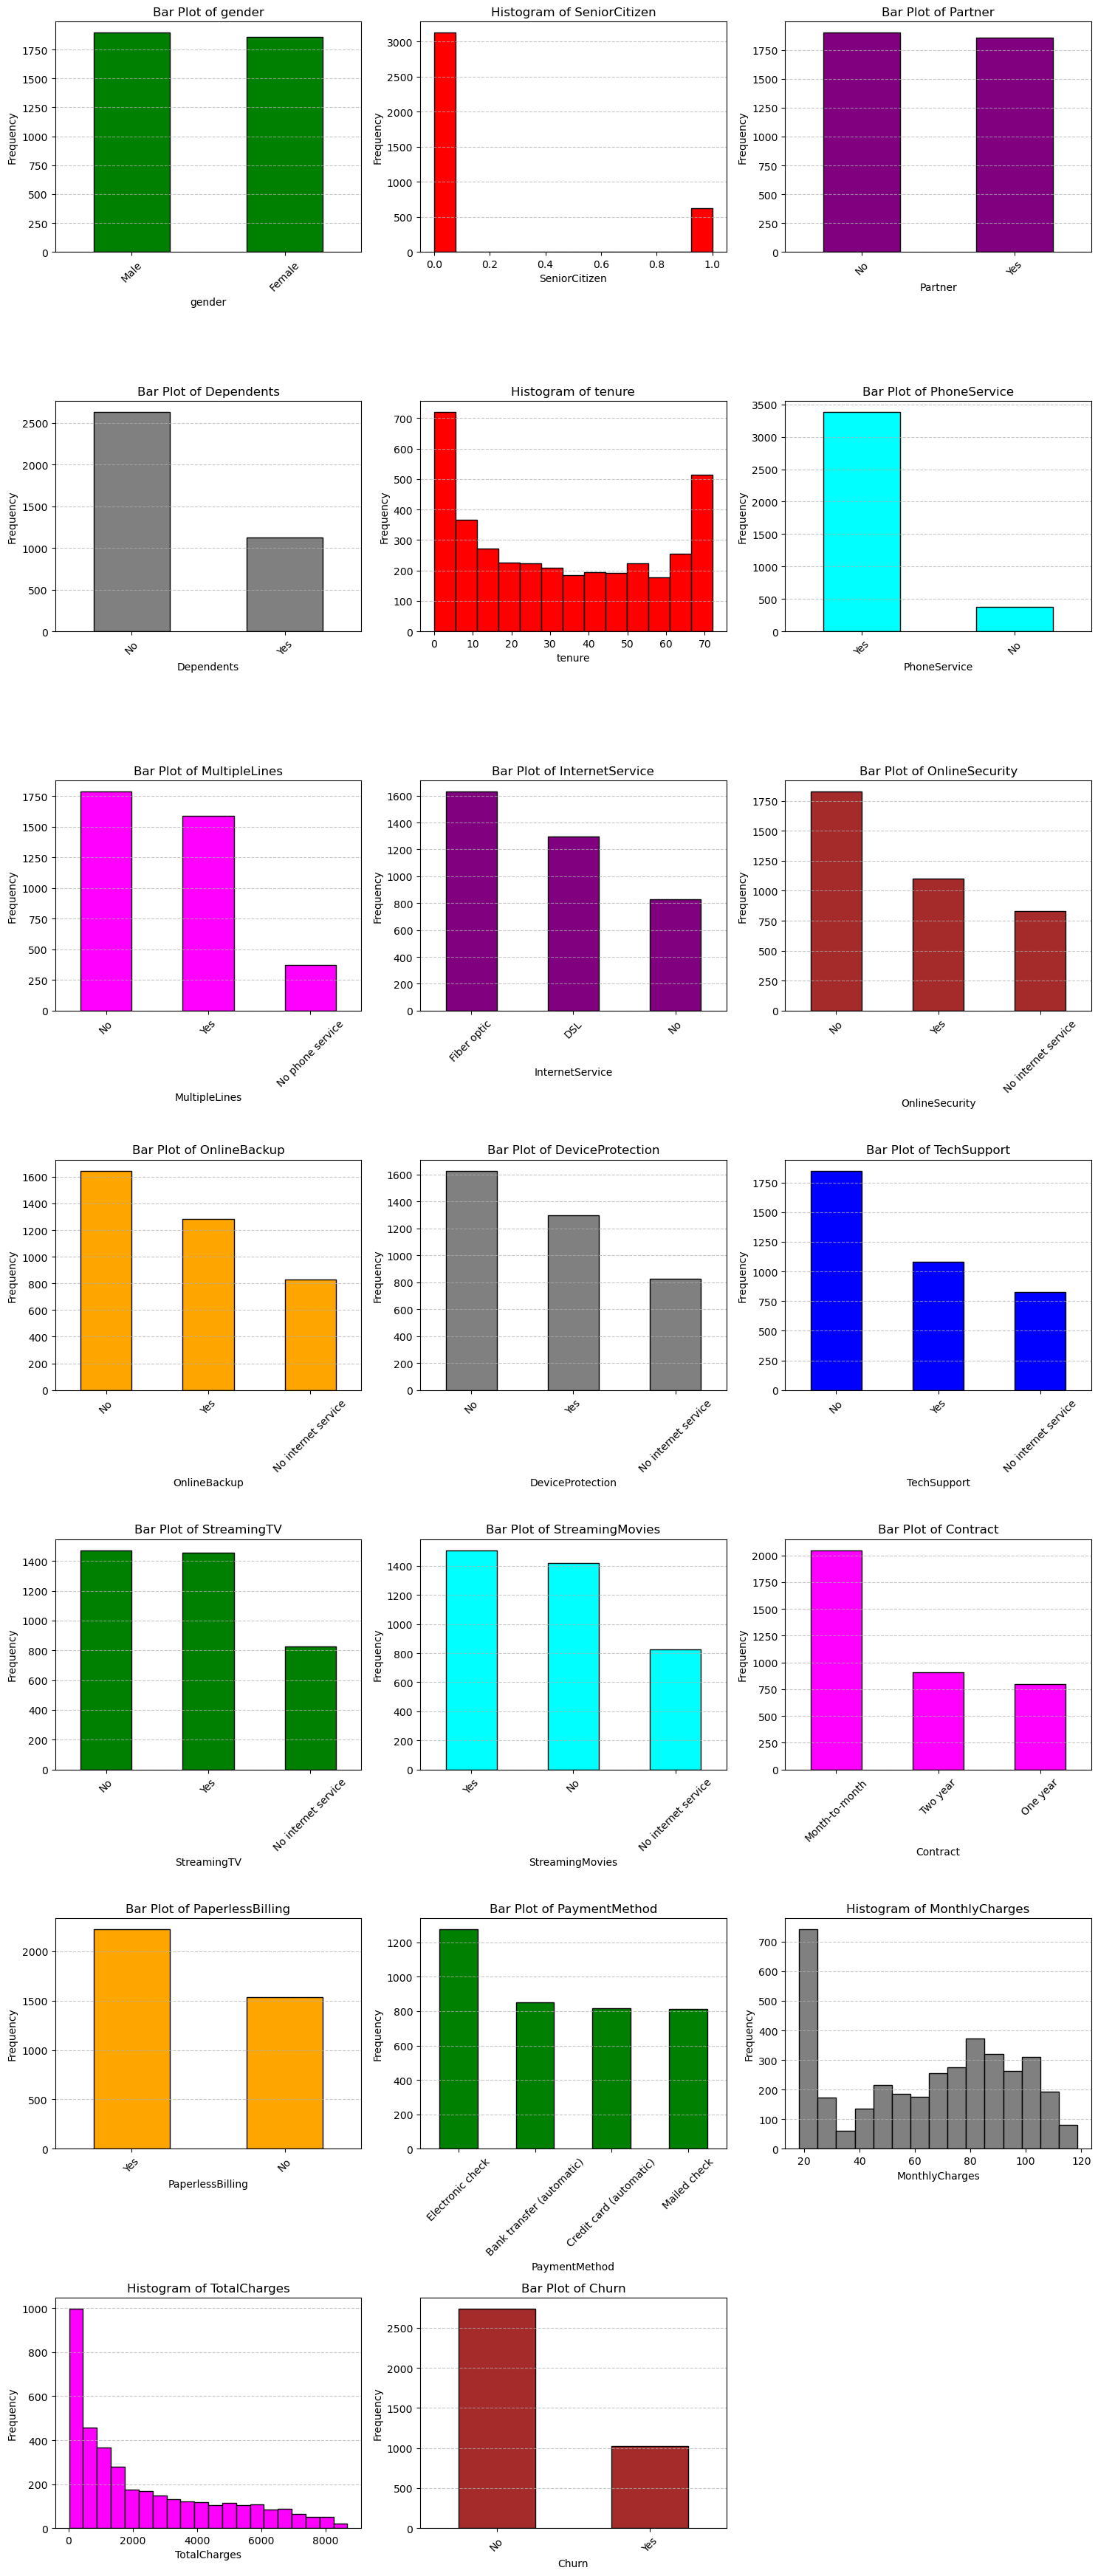

In [22]:
plotHistogram(dfTrainFoldOne)

Como podemos observar, as variáveis númericas 'tenure', 'MonthlyCharges' e 'TotallyCharges' possuem um grande variação de valores e, por isso trazem a necessidade colocar em faixas, como mostrado abaixo:

In [23]:
maxTenure, maxMonthlyCharges, maxTotallyCharges = dfTrainFoldOne['tenure'].max(), dfTrainFoldOne['MonthlyCharges'].max(), dfTrainFoldOne['TotalCharges'].max()
print(maxTenure)
print(maxMonthlyCharges)
print(maxTotallyCharges)


72
118.6
8684.8


# 4. Tratamento dos Dados

## 4.1 Tratamento de Dados Nulos

In [24]:
dfTrainFoldOne.isnull().sum() / len(dfTrainFoldOne) * 100

gender              0.00000
SeniorCitizen       0.00000
Partner             0.00000
Dependents          0.00000
tenure              0.00000
PhoneService        0.00000
MultipleLines       0.00000
InternetService     0.00000
OnlineSecurity      0.00000
OnlineBackup        0.00000
DeviceProtection    0.00000
TechSupport         0.00000
StreamingTV         0.00000
StreamingMovies     0.00000
Contract            0.00000
PaperlessBilling    0.00000
PaymentMethod       0.00000
MonthlyCharges      0.00000
TotalCharges        0.13312
Churn               0.00000
dtype: float64

### *Median Imputation*

Como aproximadamente `16%` da coluna `TotalCharges` não possui valores, optamos por utilizar a *median imputation* para preencher os valores.

In [25]:
dfTrainFoldOne, dfValFoldOne, dfTestFoldOne = fix_missing_values_median(dfTrainFoldOne.copy(), dfValFoldOne.copy(), dfTestFoldOne.copy(), "TotalCharges")

In [26]:
dfTrainFoldOne.isnull().sum() / len(dfTrainFoldOne) * 100

gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
tenure              0.0
PhoneService        0.0
MultipleLines       0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Contract            0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
Churn               0.0
dtype: float64

In [27]:
dfTestFoldOne.isnull().sum() / len(dfTestFoldOne) * 100

gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
tenure              0.0
PhoneService        0.0
MultipleLines       0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Contract            0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
Churn               0.0
dtype: float64

In [28]:
dfValFoldOne.isnull().sum() / len(dfValFoldOne) * 100

gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
tenure              0.0
PhoneService        0.0
MultipleLines       0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Contract            0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
Churn               0.0
dtype: float64

## 4.2 Tratamento de Outliers

C:\Users\maria\AppData\Local\Temp\ipykernel_12608\2271309273.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(numeric_columns, rotation=45, ha='right', fontsize=12)


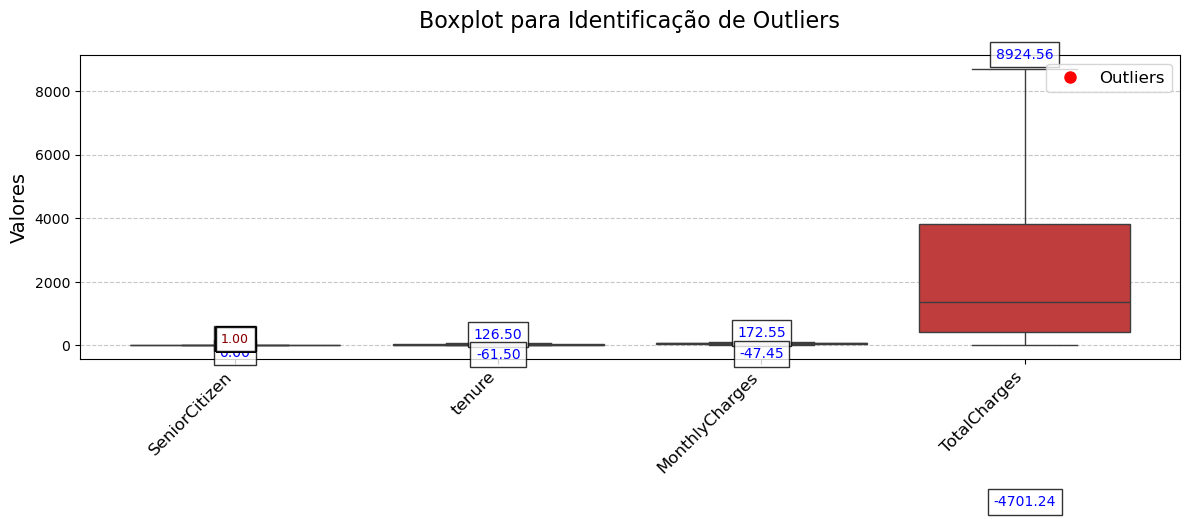

In [29]:
plot_outliers(dfTrainFoldOne)

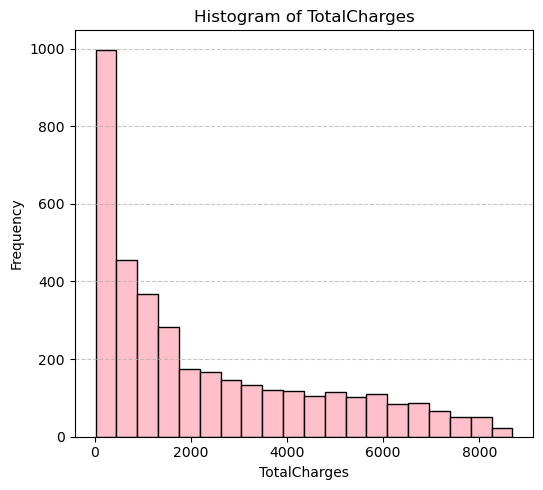

In [30]:
plotHistogram(dfTrainFoldOne['TotalCharges'])

In [31]:
dfTrainFoldOne, dfValFoldOne, dfTestFoldOne = remove_outliers(dfTrainFoldOne.copy(), dfValFoldOne.copy(), dfTestFoldOne.copy(), "TotalCharges")

In [32]:
dfTrainFoldOne["tenure"].isnull().sum()

0

In [33]:
dfTrainFoldOne, dfValFoldOne, dfTestFoldOne = bin_columns(dfTrainFoldOne.copy(), dfValFoldOne.copy(), dfTestFoldOne.copy(), "tenure")

In [34]:
dfTrainFoldOne["tenure"].isnull().sum()

0

## 4.3 Normalização de dados numéricos com Min-Max

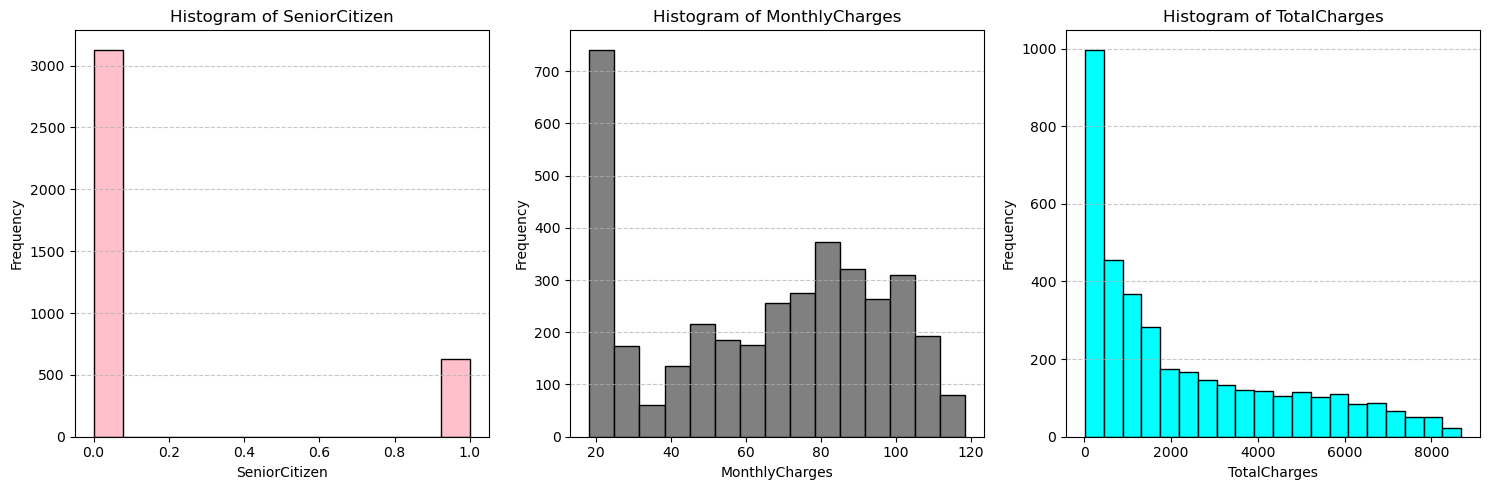

In [35]:
numeric_cols = dfTrainFoldOne.select_dtypes(include=['number'])
plotHistogram(numeric_cols)

In [36]:
dfTrainFoldOne, dfValFoldOne, dfTestFoldOne = normalize_data(dfTrainFoldOne.copy(), dfValFoldOne.copy(), dfTestFoldOne.copy())

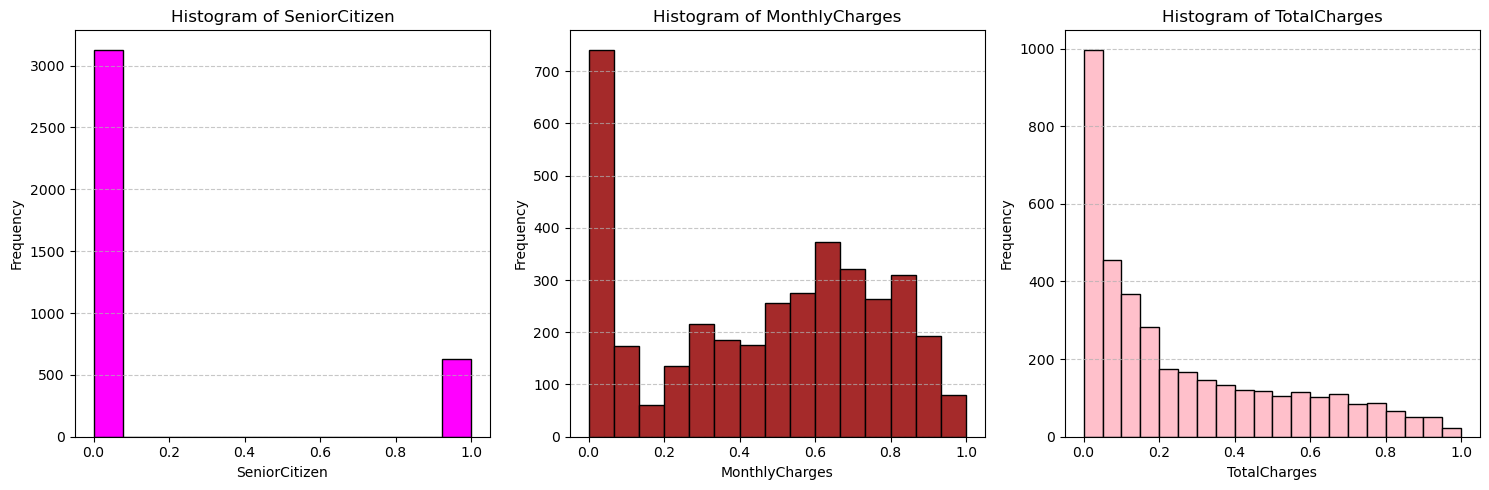

In [37]:
plotHistogram(dfTrainFoldOne[numeric_cols.columns])

## 4.4 Tratamento de Variáveis Categóricas

A seguir, transformamos as variáveis categóricas em numéricas. Para as colunas binárias, mapeamos os valores "Yes" e "No" para 1 e 0, respectivamente. Em seguida, aplicamos **One-Hot Encoding** a todas as variáveis categóricas(não necessário utilizar a codificação de bits, pois o máximo de valores únicos em uma categoria é 4), **exceto "Contract"**, pois ela possui um aspecto ordinal e deve ser codificada de forma diferente.  

Além disso, a variável numérica **"tenure"** é convertida em faixas, representando diferentes períodos de tempo, e depois transformada em valores numéricos ordinais.  

Essas transformações são realizadas nas funções **`preprocess_categorical_data`** (para variáveis categóricas) e **`bin_and_encode`** (para a variável "tenure").

In [38]:
dfTrainFoldOne, dfValFoldOne, dfTestFoldOne = preprocess_categorical_data(dfTrainFoldOne.copy(), dfValFoldOne.copy(), dfTestFoldOne.copy())

In [39]:
dfTrainFoldOne.head()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,Contract,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_Yes,OnlineBackup_No,OnlineBackup_No internet service,OnlineBackup_Yes,OnlineSecurity_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,DeviceProtection_No,DeviceProtection_No internet service,DeviceProtection_Yes
6653,0.0,0,0,1.0,0,0.0,1,0.114599,0.089067,0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
6125,0.0,1,0,0.0,1,0.0,1,0.837070,0.154645,1,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4914,0.0,1,1,3.0,1,2.0,0,0.561036,0.624490,0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
2786,0.0,0,1,1.0,1,1.0,0,0.378176,0.178711,0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
4238,0.0,1,1,3.0,1,1.0,0,0.011460,0.120327,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


## 4.4 Tratamentos nos *folds* `k=2` e `k=3`

### `k=2`

In [40]:
dfTrainFoldTwo, dfValFoldTwo, dfTestFoldTwo = fix_missing_values_median(dfTrainFoldTwo.copy(), dfValFoldTwo.copy(), dfTestFoldTwo.copy(), "TotalCharges")

In [41]:
dfTrainFoldTwo, dfValFoldTwo, dfTestFoldTwo = remove_outliers(dfTrainFoldTwo.copy(), dfValFoldTwo.copy(), dfTestFoldTwo.copy(), "TotalCharges")

In [42]:
dfTrainFoldTwo, dfValFoldTwo, dfTestFoldTwo = normalize_data(dfTrainFoldTwo.copy(), dfValFoldTwo.copy(), dfTestFoldTwo.copy())

In [43]:
dfTrainFoldTwo, dfValFoldTwo, dfTestFoldTwo = bin_columns(dfTrainFoldTwo.copy(), dfValFoldTwo.copy(), dfTestFoldTwo.copy(), "tenure")
dfTrainFoldTwo, dfValFoldTwo, dfTestFoldTwo = preprocess_categorical_data(dfTrainFoldTwo.copy(), dfValFoldTwo.copy(), dfTestFoldTwo.copy())

### `k=3`

In [44]:
dfTrainFoldThree, dfValFoldThree, dfTestFoldThree = fix_missing_values_median(dfTrainFoldThree.copy(), dfValFoldThree.copy(), dfTestFoldThree.copy(), "TotalCharges")

In [45]:
dfTrainFoldThree, dfValFoldThree, dfTestFoldThree = remove_outliers(dfTrainFoldThree.copy(), dfValFoldThree.copy(), dfTestFoldThree.copy(), "TotalCharges")

In [46]:
dfTrainFoldThree, dfValFoldThree, dfTestFoldThree = normalize_data(dfTrainFoldThree.copy(), dfValFoldThree.copy(), dfTestFoldThree.copy())

In [47]:
dfTrainFoldThree, dfValFoldThree, dfTestFoldThree = bin_columns(dfTrainFoldThree.copy(), dfValFoldThree.copy(), dfTestFoldThree.copy(), "tenure")
dfTrainFoldThree, dfValFoldThree, dfTestFoldThree = preprocess_categorical_data(dfTrainFoldThree.copy(), dfValFoldThree.copy(), dfTestFoldThree.copy())

# 5. Experimentos

## *Random Forest*

### Parâmetros que serão variados
- Número de árvores (`n_estimators`)
- Profundidade máxima (`max_depth`)
- Número mínimo de amostras para dividir um nó (`min_samples_split`)
- Critério de divisão (`criterion`)

In [60]:
#Fold One
X_train_fold_one = dfTrainFoldOne.drop("Churn", axis=1)
y_train_fold_one = dfTrainFoldOne["Churn"]
X_test_fold_one = dfTestFoldOne.drop("Churn", axis=1)
y_test_fold_one = dfTestFoldOne["Churn"]
X_val_fold_one = dfValFoldOne.drop("Churn", axis=1)
y_val_fold_one = dfValFoldOne["Churn"]
#Fold Two
X_train_fold_two = dfTrainFoldTwo.drop("Churn", axis=1)
y_train_fold_two = dfTrainFoldTwo["Churn"]
X_test_fold_two = dfTestFoldTwo.drop("Churn", axis=1)
y_test_fold_two = dfTestFoldTwo["Churn"]
X_val_fold_two = dfValFoldTwo.drop("Churn", axis=1)
y_val_fold_two = dfValFoldTwo["Churn"]
#Fold Three
X_train_fold_three = dfTrainFoldThree.drop("Churn", axis=1)
y_train_fold_three = dfTrainFoldThree["Churn"]
X_test_fold_three = dfTestFoldThree.drop("Churn", axis=1)
y_test_fold_three = dfTestFoldThree["Churn"]
X_val_fold_three = dfValFoldThree.drop("Churn", axis=1)
y_val_fold_three = dfValFoldThree["Churn"]

### Otimização com Optuna

In [49]:
def objective_RF(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    max_depth = trial.suggest_int("max_depth", 3, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    criterion = trial.suggest_categorical("criterion", ["gini", "entropy"])

    model = RandomForestClassifier(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        n_jobs=-1
    )

    # testar com o roc-auc
    score = cross_val_score(model, X_train_fold_one, y_train_fold_one, cv=3, scoring="f1").mean()
    return score

In [50]:
study_RF = optuna.create_study(direction="maximize")  
study_RF.optimize(objective_RF, n_trials=50)  

[I 2025-04-04 11:14:06,758] A new study created in memory with name: no-name-8d133684-509b-4057-828b-2c6fcd08bed6
[I 2025-04-04 11:14:07,920] Trial 0 finished with value: 0.5899268921030089 and parameters: {'n_estimators': 176, 'max_depth': 11, 'min_samples_split': 3, 'min_samples_leaf': 9, 'criterion': 'entropy'}. Best is trial 0 with value: 0.5899268921030089.
[I 2025-04-04 11:14:08,857] Trial 1 finished with value: 0.586971601328876 and parameters: {'n_estimators': 133, 'max_depth': 14, 'min_samples_split': 10, 'min_samples_leaf': 9, 'criterion': 'gini'}. Best is trial 0 with value: 0.5899268921030089.
[I 2025-04-04 11:14:09,524] Trial 2 finished with value: 0.5070630545110201 and parameters: {'n_estimators': 96, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 9, 'criterion': 'gini'}. Best is trial 0 with value: 0.5899268921030089.
[I 2025-04-04 11:14:11,181] Trial 3 finished with value: 0.5840475511541623 and parameters: {'n_estimators': 269, 'max_depth': 20, 'min_sampl

In [51]:
print("Melhores hiperparâmetros:", study_RF.best_params)

Melhores hiperparâmetros: {'n_estimators': 105, 'max_depth': 8, 'min_samples_split': 8, 'min_samples_leaf': 5, 'criterion': 'entropy'}


### Treinamento do Modelo

#### Fold One

In [65]:
print("Fold One: \n")
best_params_RF = study_RF.best_params
final_model = RandomForestClassifier(**best_params_RF, random_state=42, n_jobs=-1)
final_model.fit(X_train_fold_one, y_train_fold_one)

#Estatísticas para o Conjunto de Validação
y_pred = final_model.predict(X_val_fold_one)
accuracy_RF = accuracy_score(y_val_fold_one, y_pred)
f1_value_RF = f1_score(y_val_fold_one, y_pred)
y_probs = final_model.predict_proba(X_val_fold_one)[:, 1]
ks_statistic, _ = ks_2samp(y_probs[y_val_fold_one == 1], y_probs[y_val_fold_one == 0])

print("Acurácia final no conjunto de validação: {:.2f}%".format(accuracy_RF * 100))
print("F1-Score final no conjunto de validação: {:.2f}%".format(f1_value_RF * 100))
print("KS no conjunto de validação: {:.4f}%".format(ks_statistic * 100))

#Estatísticas para o Conjunto de Teste
y_pred = final_model.predict(X_test_fold_one)
accuracy_RF = accuracy_score(y_test_fold_one, y_pred)
f1_value_RF = f1_score(y_test_fold_one, y_pred)
y_probs = final_model.predict_proba(X_test_fold_one)[:, 1]
ks_statistic, _ = ks_2samp(y_probs[y_test_fold_one == 1], y_probs[y_test_fold_one == 0])

print("\n\nAcurácia final no conjunto de teste: {:.2f}%".format(accuracy_RF * 100))
print("F1-Score final no conjunto de teste: {:.2f}%".format(f1_value_RF * 100))
print("KS no conjunto de teste: {:.4f}%".format(ks_statistic * 100))

Fold One: 

Acurácia final no conjunto de validação: 78.17%
F1-Score final no conjunto de validação: 54.34%
KS no conjunto de validação: 51.9242%


Acurácia final no conjunto de teste: 80.75%
F1-Score final no conjunto de teste: 57.99%
KS no conjunto de teste: 53.7815%


#### Fold Two

In [66]:
print("Fold Two: \n")
best_params_RF = study_RF.best_params
final_model = RandomForestClassifier(**best_params_RF, random_state=42, n_jobs=-1)
final_model.fit(X_train_fold_two, y_train_fold_two)

#Estatísticas para o Conjunto de Validação
y_pred = final_model.predict(X_val_fold_two)
accuracy_RF = accuracy_score(y_val_fold_two, y_pred)
f1_value_RF = f1_score(y_val_fold_two, y_pred)
y_probs = final_model.predict_proba(X_val_fold_two)[:, 1]
ks_statistic, _ = ks_2samp(y_probs[y_val_fold_two == 1], y_probs[y_val_fold_two == 0])

print("Acurácia final no conjunto de validação: {:.2f}%".format(accuracy_RF * 100))
print("F1-Score final no conjunto de validação: {:.2f}%".format(f1_value_RF * 100))
print("KS no conjunto de validação: {:.4f}%".format(ks_statistic * 100))

#Estatísticas para o Conjunto de Teste
y_pred = final_model.predict(X_test_fold_two)
accuracy_RF = accuracy_score(y_test_fold_two, y_pred)
f1_value_RF = f1_score(y_test_fold_two, y_pred)
y_probs = final_model.predict_proba(X_test_fold_two)[:, 1]
ks_statistic, _ = ks_2samp(y_probs[y_test_fold_two == 1], y_probs[y_test_fold_two == 0])

print("\n\nAcurácia final no conjunto de teste: {:.2f}%".format(accuracy_RF * 100))
print("F1-Score final no conjunto de teste: {:.2f}%".format(f1_value_RF * 100))
print("KS no conjunto de teste: {:.4f}%".format(ks_statistic * 100))

Fold Two: 

Acurácia final no conjunto de validação: 79.66%
F1-Score final no conjunto de validação: 59.28%
KS no conjunto de validação: 53.9645%


Acurácia final no conjunto de teste: 79.00%
F1-Score final no conjunto de teste: 54.31%
KS no conjunto de teste: 51.9231%


#### Fold Three

In [67]:
print("Fold Three: \n")
best_params_RF = study_RF.best_params
final_model = RandomForestClassifier(**best_params_RF, random_state=42, n_jobs=-1)
final_model.fit(X_train_fold_three, y_train_fold_three)

#Estatísticas para o Conjunto de Validação
y_pred = final_model.predict(X_val_fold_three)
accuracy_RF = accuracy_score(y_val_fold_three, y_pred)
f1_value_RF = f1_score(y_val_fold_three, y_pred)
y_probs = final_model.predict_proba(X_val_fold_three)[:, 1]
ks_statistic, _ = ks_2samp(y_probs[y_val_fold_three == 1], y_probs[y_val_fold_three == 0])

print("Acurácia final no conjunto de validação: {:.2f}%".format(accuracy_RF * 100))
print("F1-Score final no conjunto de validação: {:.2f}%".format(f1_value_RF * 100))
print("KS no conjunto de validação: {:.4f}%".format(ks_statistic * 100))

#Estatísticas para o Conjunto de Teste
y_pred = final_model.predict(X_test_fold_three)
accuracy_RF = accuracy_score(y_test_fold_three, y_pred)
f1_value_RF = f1_score(y_test_fold_three, y_pred)
y_probs = final_model.predict_proba(X_test_fold_three)[:, 1]
ks_statistic, _ = ks_2samp(y_probs[y_test_fold_three == 1], y_probs[y_test_fold_three == 0])

print("\n\nAcurácia final no conjunto de teste: {:.2f}%".format(accuracy_RF * 100))
print("F1-Score final no conjunto de teste: {:.2f}%".format(f1_value_RF * 100))
print("KS no conjunto de teste: {:.4f}%".format(ks_statistic * 100))

Fold Three: 

Acurácia final no conjunto de validação: 78.94%
F1-Score final no conjunto de validação: 55.41%
KS no conjunto de validação: 54.1001%


Acurácia final no conjunto de teste: 80.14%
F1-Score final no conjunto de teste: 57.40%
KS no conjunto de teste: 54.7968%


## MLP

### Parâmetros que serão variados

- Número de camadas
- Número de neurônios
- Taxa de aprendizagem
- Otimização

In [69]:
print("CUDA disponível:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
print("Versão do PyTorch:", torch.__version__)

CUDA disponível: True
GPU: NVIDIA GeForce RTX 3050 Laptop GPU
Versão do PyTorch: 2.6.0+cu118


### Otimização com Optuna

In [70]:
def objective_MLP_Cuda(trial):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    n_neurons = trial.suggest_int("n_neurons", 10, 200)
    activation_name = trial.suggest_categorical("activation", ["relu", "tanh", "logistic"])
    learning_rate = trial.suggest_float("learning_rate_init", 1e-5, 1e-2, log=True)

    input_size = X_train_fold_one.shape[1]
    output_size = len(np.unique(y_train_fold_one))

    layers = [nn.Linear(input_size, n_neurons)]
    if activation_name == "relu":
        layers.append(nn.ReLU())
    elif activation_name == "tanh":
        layers.append(nn.Tanh())
    elif activation_name == "logistic":
        layers.append(nn.Sigmoid())
    layers.append(nn.Linear(n_neurons, output_size))

    model = nn.Sequential(*layers).to(device)

    X_train_tensor = torch.tensor(X_train_fold_one.to_numpy(), dtype=torch.float32).to(device)
    y_train_tensor = torch.tensor(y_train_fold_one.to_numpy(), dtype=torch.long).to(device)
    X_test_tensor = torch.tensor(X_test_fold_one.to_numpy(), dtype=torch.float32).to(device)
    y_test_tensor = torch.tensor(y_test_fold_one.to_numpy(), dtype=torch.long)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    for epoch in range(100):
        optimizer.zero_grad()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        outputs = model(X_test_tensor)
        _, y_pred = torch.max(outputs, 1)

    f1 = f1_score(y_test_tensor.cpu(), y_pred.cpu(), average="macro")
    return f1

In [71]:
study_MLP = optuna.create_study(direction="maximize")
study_MLP.optimize(objective_MLP_Cuda, n_trials=50)

print("Melhores hiperparâmetros:", study_MLP.best_params)

[I 2025-04-04 11:28:23,055] A new study created in memory with name: no-name-cb5fa829-89b5-4bf6-83b2-f6091aa58d99
[I 2025-04-04 11:28:26,280] Trial 0 finished with value: 0.7254564651849948 and parameters: {'n_neurons': 58, 'activation': 'tanh', 'learning_rate_init': 0.0031877565237226277}. Best is trial 0 with value: 0.7254564651849948.
[I 2025-04-04 11:28:26,504] Trial 1 finished with value: 0.7035797730239978 and parameters: {'n_neurons': 56, 'activation': 'relu', 'learning_rate_init': 0.0003884373704864274}. Best is trial 0 with value: 0.7254564651849948.
[I 2025-04-04 11:28:26,719] Trial 2 finished with value: 0.4267578125 and parameters: {'n_neurons': 157, 'activation': 'logistic', 'learning_rate_init': 0.00012048970317720644}. Best is trial 0 with value: 0.7254564651849948.
[I 2025-04-04 11:28:26,932] Trial 3 finished with value: 0.6863172717589501 and parameters: {'n_neurons': 88, 'activation': 'tanh', 'learning_rate_init': 0.00026149438726053503}. Best is trial 0 with value: 0

Melhores hiperparâmetros: {'n_neurons': 156, 'activation': 'relu', 'learning_rate_init': 0.004169969691239405}


### Treinamento do Modelo

#### Fold One

In [78]:
# Converte os dados para tensor
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train_tensor = torch.tensor(X_train_fold_one.to_numpy(), dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_fold_one.to_numpy(), dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test_fold_one.to_numpy(), dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_fold_one.to_numpy(), dtype=torch.long)
X_val_tensor = torch.tensor(X_val_fold_one.to_numpy(), dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val_fold_one.to_numpy(), dtype=torch.long).to(device)

best_params_MLP = study_MLP.best_params
n_neurons = best_params_MLP["n_neurons"]
activation_name = best_params_MLP["activation"]
learning_rate = best_params_MLP["learning_rate_init"]

input_size = X_train_fold_one.shape[1]
output_size = len(torch.unique(y_train_tensor))

layers = [nn.Linear(input_size, n_neurons)]
if activation_name == "relu":
    layers.append(nn.ReLU())
elif activation_name == "tanh":
    layers.append(nn.Tanh())
elif activation_name == "logistic":
    layers.append(nn.Sigmoid())
layers.append(nn.Linear(n_neurons, output_size))

model = nn.Sequential(*layers).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model.train()
for epoch in range(100):  # Pode ajustar epochs
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        val_preds = torch.argmax(val_outputs, dim=1)
        val_acc = (val_preds == y_val_tensor).float().mean().item()
    
    print(f"Epoch {epoch+1}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val Acc: {val_acc:.4f}")

model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)  
    probabilities = torch.softmax(outputs, dim=1)  
    y_probs = probabilities[:, 1].cpu().numpy()  
    y_pred = torch.argmax(outputs, dim=1)
    
y_pred_cpu = y_pred.cpu().numpy()
y_test_cpu = y_test_tensor.cpu().numpy()

acc = accuracy_score(y_test_cpu, y_pred_cpu)
f1 = f1_score(y_test_cpu, y_pred_cpu, average="macro")

ks_statistic, _ = ks_2samp(y_probs[y_test_cpu == 1], y_probs[y_test_cpu == 0])

print("\n\nAcurácia final: {:.2f}%".format(acc * 100))
print("F1-Score final: {:.2f}%".format(f1 * 100))
print("KS: {:.4f}%".format(ks_statistic*100))

Epoch 1, Train Loss: 0.7766, Val Loss: 0.6449, Val Acc: 0.7157
Epoch 2, Train Loss: 0.6465, Val Loss: 0.5794, Val Acc: 0.7348
Epoch 3, Train Loss: 0.5804, Val Loss: 0.5504, Val Acc: 0.7348
Epoch 4, Train Loss: 0.5503, Val Loss: 0.5358, Val Acc: 0.7348
Epoch 5, Train Loss: 0.5338, Val Loss: 0.5225, Val Acc: 0.7348
Epoch 6, Train Loss: 0.5178, Val Loss: 0.5066, Val Acc: 0.7348
Epoch 7, Train Loss: 0.4986, Val Loss: 0.4896, Val Acc: 0.7359
Epoch 8, Train Loss: 0.4776, Val Loss: 0.4748, Val Acc: 0.7465
Epoch 9, Train Loss: 0.4581, Val Loss: 0.4654, Val Acc: 0.7678
Epoch 10, Train Loss: 0.4436, Val Loss: 0.4634, Val Acc: 0.7742
Epoch 11, Train Loss: 0.4359, Val Loss: 0.4683, Val Acc: 0.7636
Epoch 12, Train Loss: 0.4350, Val Loss: 0.4766, Val Acc: 0.7657
Epoch 13, Train Loss: 0.4381, Val Loss: 0.4826, Val Acc: 0.7646
Epoch 14, Train Loss: 0.4406, Val Loss: 0.4831, Val Acc: 0.7614
Epoch 15, Train Loss: 0.4397, Val Loss: 0.4788, Val Acc: 0.7678
Epoch 16, Train Loss: 0.4361, Val Loss: 0.4725, V

#### Fold Two

In [76]:
# Converte os dados para tensor
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train_tensor = torch.tensor(X_train_fold_two.to_numpy(), dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_fold_two.to_numpy(), dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test_fold_two.to_numpy(), dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_fold_two.to_numpy(), dtype=torch.long)
X_val_tensor = torch.tensor(X_val_fold_two.to_numpy(), dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val_fold_two.to_numpy(), dtype=torch.long).to(device)

best_params_MLP = study_MLP.best_params
n_neurons = best_params_MLP["n_neurons"]
activation_name = best_params_MLP["activation"]
learning_rate = best_params_MLP["learning_rate_init"]

input_size = X_train_fold_two.shape[1]
output_size = len(torch.unique(y_train_tensor))

layers = [nn.Linear(input_size, n_neurons)]
if activation_name == "relu":
    layers.append(nn.ReLU())
elif activation_name == "tanh":
    layers.append(nn.Tanh())
elif activation_name == "logistic":
    layers.append(nn.Sigmoid())
layers.append(nn.Linear(n_neurons, output_size))

model = nn.Sequential(*layers).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model.train()
for epoch in range(100):  # Pode ajustar epochs
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        val_preds = torch.argmax(val_outputs, dim=1)
        val_acc = (val_preds == y_val_tensor).float().mean().item()
    
    print(f"Epoch {epoch+1}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val Acc: {val_acc:.4f}")

model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)  
    probabilities = torch.softmax(outputs, dim=1)  
    y_probs = probabilities[:, 1].cpu().numpy()
    y_pred = torch.argmax(outputs, dim=1)

y_pred_cpu = y_pred.cpu().numpy()
y_test_cpu = y_test_tensor.cpu().numpy()

acc = accuracy_score(y_test_cpu, y_pred_cpu)
f1 = f1_score(y_test_cpu, y_pred_cpu, average="macro")

ks_statistic, _ = ks_2samp(y_probs[y_test_cpu == 1], y_probs[y_test_cpu == 0])

print("\n\nAcurácia final: {:.2f}%".format(acc * 100))
print("F1-Score final: {:.2f}%".format(f1 * 100))
print("KS: {:.4f}%".format(ks_statistic * 100))

Epoch 1, Train Loss: 0.6966, Val Loss: 0.6062, Val Acc: 0.7125
Epoch 2, Train Loss: 0.5976, Val Loss: 0.5649, Val Acc: 0.7125
Epoch 3, Train Loss: 0.5443, Val Loss: 0.5527, Val Acc: 0.7125
Epoch 4, Train Loss: 0.5227, Val Loss: 0.5503, Val Acc: 0.7125
Epoch 5, Train Loss: 0.5148, Val Loss: 0.5443, Val Acc: 0.7125
Epoch 6, Train Loss: 0.5072, Val Loss: 0.5308, Val Acc: 0.7125
Epoch 7, Train Loss: 0.4950, Val Loss: 0.5120, Val Acc: 0.7125
Epoch 8, Train Loss: 0.4794, Val Loss: 0.4922, Val Acc: 0.7125
Epoch 9, Train Loss: 0.4636, Val Loss: 0.4752, Val Acc: 0.7391
Epoch 10, Train Loss: 0.4508, Val Loss: 0.4632, Val Acc: 0.7614
Epoch 11, Train Loss: 0.4427, Val Loss: 0.4567, Val Acc: 0.7891
Epoch 12, Train Loss: 0.4392, Val Loss: 0.4542, Val Acc: 0.7934
Epoch 13, Train Loss: 0.4390, Val Loss: 0.4538, Val Acc: 0.7891
Epoch 14, Train Loss: 0.4397, Val Loss: 0.4534, Val Acc: 0.7838
Epoch 15, Train Loss: 0.4394, Val Loss: 0.4518, Val Acc: 0.7870
Epoch 16, Train Loss: 0.4371, Val Loss: 0.4497, V

#### Fold Three

In [77]:
# Converte os dados para tensor
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_train_tensor = torch.tensor(X_train_fold_three.to_numpy(), dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_fold_three.to_numpy(), dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test_fold_three.to_numpy(), dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_fold_three.to_numpy(), dtype=torch.long)
X_val_tensor = torch.tensor(X_val_fold_three.to_numpy(), dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val_fold_three.to_numpy(), dtype=torch.long).to(device)

best_params_MLP = study_MLP.best_params
n_neurons = best_params_MLP["n_neurons"]
activation_name = best_params_MLP["activation"]
learning_rate = best_params_MLP["learning_rate_init"]

input_size = X_train_fold_two.shape[1]
output_size = len(torch.unique(y_train_tensor))

layers = [nn.Linear(input_size, n_neurons)]
if activation_name == "relu":
    layers.append(nn.ReLU())
elif activation_name == "tanh":
    layers.append(nn.Tanh())
elif activation_name == "logistic":
    layers.append(nn.Sigmoid())
layers.append(nn.Linear(n_neurons, output_size))

model = nn.Sequential(*layers).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

model.train()
for epoch in range(100):  # Pode ajustar epochs
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    model.eval()
    with torch.no_grad():
        val_outputs = model(X_val_tensor)
        val_loss = criterion(val_outputs, y_val_tensor)
        val_preds = torch.argmax(val_outputs, dim=1)
        val_acc = (val_preds == y_val_tensor).float().mean().item()
    
    print(f"Epoch {epoch+1}, Train Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}, Val Acc: {val_acc:.4f}")

model.eval()
with torch.no_grad():
    outputs = model(X_test_tensor)  
    probabilities = torch.softmax(outputs, dim=1)  
    y_probs = probabilities[:, 1].cpu().numpy()
    y_pred = torch.argmax(outputs, dim=1)

y_pred_cpu = y_pred.cpu().numpy()
y_test_cpu = y_test_tensor.cpu().numpy()

acc = accuracy_score(y_test_cpu, y_pred_cpu)
f1 = f1_score(y_test_cpu, y_pred_cpu, average="macro")

ks_statistic, _ = ks_2samp(y_probs[y_test_cpu == 1], y_probs[y_test_cpu == 0])

print("\n\nAcurácia final: {:.2f}%".format(acc * 100))
print("F1-Score final: {:.2f}%".format(f1 * 100))
print("KS: {:.4f}%".format(ks_statistic * 100))

Epoch 1, Train Loss: 0.7474, Val Loss: 0.6420, Val Acc: 0.7309
Epoch 2, Train Loss: 0.6404, Val Loss: 0.5859, Val Acc: 0.7309
Epoch 3, Train Loss: 0.5807, Val Loss: 0.5607, Val Acc: 0.7309
Epoch 4, Train Loss: 0.5534, Val Loss: 0.5489, Val Acc: 0.7309
Epoch 5, Train Loss: 0.5408, Val Loss: 0.5386, Val Acc: 0.7309
Epoch 6, Train Loss: 0.5310, Val Loss: 0.5252, Val Acc: 0.7309
Epoch 7, Train Loss: 0.5185, Val Loss: 0.5089, Val Acc: 0.7309
Epoch 8, Train Loss: 0.5032, Val Loss: 0.4921, Val Acc: 0.7309
Epoch 9, Train Loss: 0.4873, Val Loss: 0.4772, Val Acc: 0.7309
Epoch 10, Train Loss: 0.4730, Val Loss: 0.4658, Val Acc: 0.7543
Epoch 11, Train Loss: 0.4620, Val Loss: 0.4585, Val Acc: 0.7755
Epoch 12, Train Loss: 0.4549, Val Loss: 0.4549, Val Acc: 0.7766
Epoch 13, Train Loss: 0.4513, Val Loss: 0.4539, Val Acc: 0.7766
Epoch 14, Train Loss: 0.4501, Val Loss: 0.4538, Val Acc: 0.7830
Epoch 15, Train Loss: 0.4497, Val Loss: 0.4532, Val Acc: 0.7883
Epoch 16, Train Loss: 0.4489, Val Loss: 0.4513, V

## KAN

### Parâmetros que serão variados

## *Transformer*

### Parâmetros que serão variados

## KAN *Transformer*

### Parâmetros que serão variados

## *Gradient Boosting*

### Parâmetros que serão variados
- Número de estimadores
- Taxa de aprendizagem
- Profundidade Máxima
- Mínimo de amostras para divisão
- Mínimo de amostras na folha
- Fração de amostras

In [61]:
#Fold One
X_train_fold_one = dfTrainFoldOne.drop("Churn", axis=1)
y_train_fold_one = dfTrainFoldOne["Churn"]
X_test_fold_one = dfTestFoldOne.drop("Churn", axis=1)
y_test_fold_one = dfTestFoldOne["Churn"]
#Fold Two
X_train_fold_two = dfTrainFoldTwo.drop("Churn", axis=1)
y_train_fold_two = dfTrainFoldTwo["Churn"]
X_test_fold_two = dfTestFoldTwo.drop("Churn", axis=1)
y_test_fold_two = dfTestFoldTwo["Churn"]
#Fold Three
X_train_fold_three = dfTrainFoldThree.drop("Churn", axis=1)
y_train_fold_three = dfTrainFoldThree["Churn"]
X_test_fold_three = dfTestFoldThree.drop("Churn", axis=1)
y_test_fold_three = dfTestFoldThree["Churn"]

### Otimização com Optuna

In [62]:
def objective_GB(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 300)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
    max_depth = trial.suggest_int("max_depth", 3, 20)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 10)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    subsample = trial.suggest_float("subsample", 0.5, 1.0)

    model = GradientBoostingClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        subsample=subsample,
        random_state=42
    )

    score = cross_val_score(model, X_train_fold_one, y_train_fold_one, cv=3, scoring="f1").mean()
    return score

In [63]:
study_GB = optuna.create_study(direction="maximize")
study_GB.optimize(objective_GB, n_trials=50)

[I 2025-04-04 10:02:53,649] A new study created in memory with name: no-name-7470e9c1-7bc3-4fd3-9ca1-6e5923488f9d
[I 2025-04-04 10:03:12,618] Trial 0 finished with value: 0.5565443480535911 and parameters: {'n_estimators': 246, 'learning_rate': 0.13014003272073885, 'max_depth': 9, 'min_samples_split': 5, 'min_samples_leaf': 2, 'subsample': 0.9032243084682442}. Best is trial 0 with value: 0.5565443480535911.
[I 2025-04-04 10:03:29,484] Trial 1 finished with value: 0.5559551884939525 and parameters: {'n_estimators': 136, 'learning_rate': 0.08859901578515192, 'max_depth': 20, 'min_samples_split': 7, 'min_samples_leaf': 5, 'subsample': 0.8607494287715504}. Best is trial 0 with value: 0.5565443480535911.
[I 2025-04-04 10:03:34,993] Trial 2 finished with value: 0.5770208370447064 and parameters: {'n_estimators': 107, 'learning_rate': 0.03933280334194219, 'max_depth': 9, 'min_samples_split': 9, 'min_samples_leaf': 4, 'subsample': 0.5654316875638769}. Best is trial 2 with value: 0.577020837044

### Treinamento do Modelo

#### Fold One

In [67]:
best_params_GB = study_GB.best_params

final_model = GradientBoostingClassifier(
    **best_params_GB,
    random_state=42
)

final_model.fit(X_train_fold_one, y_train_fold_one)

y_pred = final_model.predict(X_test_fold_one)
accuracy_GB = accuracy_score(y_test_fold_one, y_pred)
f1_value_GB = f1_score(y_test_fold_one, y_pred)
y_probs = final_model.predict_proba(X_test_fold_one)[:, 1]
ks_statistic, _ = ks_2samp(y_probs[y_test_fold_one == 1], y_probs[y_test_fold_one == 0])

print("Acurácia final: {:.2f}%".format(accuracy_GB * 100))
print("F1-Score final: {:.2f}%".format(f1_value_GB * 100))
print("KS: {:.4f}%".format(ks_statistic * 100))

Acurácia final: 80.11%
F1-Score final: 58.19%
KS: 51.3511%


#### Fold Two

In [68]:
best_params_GB = study_GB.best_params

final_model = GradientBoostingClassifier(
    **best_params_GB,
    random_state=42
)

final_model.fit(X_train_fold_two, y_train_fold_two)

y_pred = final_model.predict(X_test_fold_two)
accuracy_GB = accuracy_score(y_test_fold_two, y_pred)
f1_value_GB = f1_score(y_test_fold_two, y_pred)
y_probs = final_model.predict_proba(X_test_fold_two)[:, 1]
ks_statistic, _ = ks_2samp(y_probs[y_test_fold_two == 1], y_probs[y_test_fold_two == 0])

print("Acurácia final: {:.2f}%".format(accuracy_GB * 100))
print("F1-Score final: {:.2f}%".format(f1_value_GB * 100))
print("KS: {:.4f}%".format(ks_statistic * 100))

Acurácia final: 78.66%
F1-Score final: 58.08%
KS: 52.5124%


#### Fold Three

In [69]:
best_params_GB = study_GB.best_params

final_model = GradientBoostingClassifier(
    **best_params_GB,
    random_state=42
)

final_model.fit(X_train_fold_three, y_train_fold_three)

y_pred = final_model.predict(X_test_fold_three)
accuracy_GB = accuracy_score(y_test_fold_three, y_pred)
f1_value_GB = f1_score(y_test_fold_three, y_pred)
y_probs = final_model.predict_proba(X_test_fold_three)[:, 1]
ks_statistic, _ = ks_2samp(y_probs[y_test_fold_three == 1], y_probs[y_test_fold_three == 0])

print("Acurácia final: {:.2f}%".format(accuracy_GB * 100))
print("F1-Score final: {:.2f}%".format(f1_value_GB * 100))
print("KS: {:.4f}%".format(ks_statistic * 100))

Acurácia final: 80.32%
F1-Score final: 58.30%
KS: 56.1101%
